In [146]:
import pandas as pd
import time
import datetime
import collections
import numpy as np
import random
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import GroupShuffleSplit
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import ndcg_score
from sklearn.preprocessing import LabelEncoder
from sklearn.utils.multiclass import type_of_target

In [147]:
df = pd.read_csv("training_set_VU_DM.csv")
df_test = pd.read_csv("test_set_VU_DM.csv")

In [148]:
df[df.columns[1:]].corr()['booking_bool'][:-1]

site_id                       -0.001354
visitor_location_country_id    0.002524
visitor_hist_starrating       -0.002044
visitor_hist_adr_usd           0.000602
prop_country_id                0.001227
prop_id                       -0.000508
prop_starrating                0.021206
prop_review_score              0.025800
prop_brand_bool                0.009991
prop_location_score1          -0.003273
prop_location_score2           0.066405
prop_log_historical_price     -0.000807
position                      -0.147918
price_usd                      0.000067
promotion_flag                 0.036047
srch_destination_id            0.000800
srch_length_of_stay           -0.024412
srch_booking_window           -0.019582
srch_adults_count             -0.005376
srch_children_count            0.003872
srch_room_count                0.007948
srch_saturday_night_bool       0.005478
srch_query_affinity_score      0.025524
orig_destination_distance     -0.003687
random_bool                   -0.088891


In [149]:
# Make a descriptive dataframe
df_descr = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
visitor_hist_starrating,312,4706481,251866,float64,5.0,1.41
visitor_hist_adr_usd,7799,4705359,252988,float64,1958.7,0.0
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,7364,4950983,float64,5.0,0.0


In [150]:
# descr2 = df_descr[df_descr['Unique values'] <= 10].index.tolist() # (almost) all are categorical variables
# descr3 = df_descr[df_descr['Unique values'] > 50].index.tolist() # (almost) all are numerical variables


# df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)
# descr3.remove('date_time')
# descr3.remove('srch_id')
# #df.boxplot(column=descr3, figsize=(16, 20))

In [151]:
#df[descr2].hist(figsize=(16, 20), bins=10, xlabelsize=8, ylabelsize=8)

In [152]:
# df_numerical = df[descr3]

# red_circle = dict(markerfacecolor = 'red', marker = 'o', markeredgecolor = 'white')

# fig, axs = plt.subplots(11, 2, figsize=(15,25))

# for i, ax in enumerate(axs.flat):
#     ax.boxplot(df_numerical.iloc[:,i].dropna(), flierprops = red_circle, vert=False)
#     ax.set_title(df_numerical.columns[i], fontweight = 'bold')
#     ax.tick_params(axis = 'y', labelsize = 14)

# plt.show()

<AxesSubplot:>

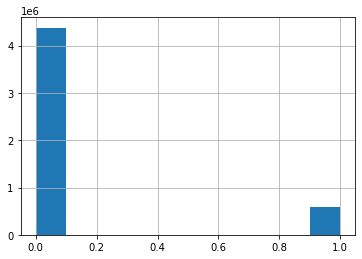

In [153]:
conditions = [(df['comp1_rate'].eq(-1) & df['comp1_inv'].ne(1)), 
              (df['comp2_rate'].eq(-1) & df['comp2_inv'].ne(1)), 
              (df['comp3_rate'].eq(-1) & df['comp3_inv'].ne(1)),  
              (df['comp4_rate'].eq(-1) & df['comp4_inv'].ne(1)), 
              (df['comp5_rate'].eq(-1) & df['comp5_inv'].ne(1)), 
              (df['comp6_rate'].eq(-1) & df['comp6_inv'].ne(1)), 
              (df['comp7_rate'].eq(-1) & df['comp7_inv'].ne(1)),  
              (df['comp8_rate'].eq(-1) & df['comp8_inv'].ne(1))]

choices = [1,1,1,1,1,1,1,1]

df['comp_cheaper'] = np.select(conditions, choices, default=0)

# and for test set
conditions2 = [(df_test['comp1_rate'].eq(-1) & df_test['comp1_inv'].ne(1)), 
              (df_test['comp2_rate'].eq(-1) & df_test['comp2_inv'].ne(1)), 
              (df_test['comp3_rate'].eq(-1) & df_test['comp3_inv'].ne(1)),  
              (df_test['comp4_rate'].eq(-1) & df_test['comp4_inv'].ne(1)), 
              (df_test['comp5_rate'].eq(-1) & df_test['comp5_inv'].ne(1)), 
              (df_test['comp6_rate'].eq(-1) & df_test['comp6_inv'].ne(1)), 
              (df_test['comp7_rate'].eq(-1) & df_test['comp7_inv'].ne(1)),  
              (df_test['comp8_rate'].eq(-1) & df_test['comp8_inv'].ne(1))]

choices2 = [1,1,1,1,1,1,1,1]

df_test['comp_cheaper'] = np.select(conditions2, choices2, default=0)
df_test['comp_cheaper'].hist()

In [154]:
## Make booleans of all columns with a lot of missing values

all_rates = ['comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
       'comp8_rate_percent_diff', 'srch_query_affinity_score', 'visitor_hist_starrating', 'visitor_hist_adr_usd']

for r in all_rates:
    df[r] = (df[r].isnull())
    df[r] = df[r].astype(int)
    df_test[r] = (df_test[r].isnull())
    df_test[r] = df_test[r].astype(int)
    
df.nunique()

srch_id                        199795
date_time                      198615
site_id                            34
visitor_location_country_id       210
visitor_hist_starrating             2
visitor_hist_adr_usd                2
prop_country_id                   172
prop_id                        129113
prop_starrating                     6
prop_review_score                  10
prop_brand_bool                     2
prop_location_score1              337
prop_location_score2             9342
prop_log_historical_price         392
position                           40
price_usd                       76465
promotion_flag                      2
srch_destination_id             18127
srch_length_of_stay                36
srch_booking_window               429
srch_adults_count                   9
srch_children_count                10
srch_room_count                     8
srch_saturday_night_bool            2
srch_query_affinity_score           2
orig_destination_distance      530595
random_bool 

In [155]:
for c in df.columns:
    if c == 'prop_review_score':
        df[c] = df[c].fillna(df[c].mode()[0])
    elif c == 'prop_location_score2':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].mean()
    elif c == 'orig_destination_distance':
        df.loc[df.loc[:,c].isnull(),c]=df.loc[:,c].mean()

for c in df_test.columns:
    if c == 'prop_review_score':
        df_test[c] = df_test[c].fillna(df_test[c].mode()[0])
    elif c == 'prop_location_score2':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].mean()
    elif c == 'orig_destination_distance':
        df_test.loc[df_test.loc[:,c].isnull(),c]=df_test.loc[:,c].mean()
        
        

print("count of NULL values after imputation\n")
print(df['prop_review_score'].isnull().sum())
print(df['prop_location_score2'].isnull().sum())   
print(df['gross_bookings_usd'].isnull().sum())

count of NULL values after imputation

0
0
4819957


In [156]:
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_adults_count', 'srch_children_count', 'srch_room_count',
       'srch_saturday_night_bool', 'srch_query_affinity_score',
       'orig_destination_distance', 'random_bool', 'comp1_rate', 'comp1_inv',
       'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
       'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate'

In [157]:
# For train set
adults = df['srch_adults_count'].values
children = df['srch_children_count'].values

adults = list(adults)
children = list(children)

ratio_adults = [i/ (i+j) for i, j in zip(adults, children)]

df.drop('srch_adults_count', inplace=True, axis=1)
df.drop('srch_children_count', inplace=True, axis=1)
df.insert(22, 'adult_ratio', ratio_adults)

# For test set

adults = df_test['srch_adults_count'].values
children = df_test['srch_children_count'].values

adults = list(adults)
children = list(children)

ratio_adults = [i/ (i+j) for i, j in zip(adults, children)]

df_test.drop('srch_adults_count', inplace=True, axis=1)
df_test.drop('srch_children_count', inplace=True, axis=1)
df_test.insert(22, 'adult_ratio', ratio_adults)

In [158]:
print(len(df.columns), len(df_test.columns))

54 50


In [159]:
df.columns

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_room_count', 'srch_saturday_night_bool', 'adult_ratio',
       'srch_query_affinity_score', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate',
       'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_pe

In [160]:
print(df.columns)

df_descr_two = pd.concat([df.nunique(), df.isna().sum(), df.notna().sum(), df.dtypes, df.max(), df.min()], axis=1)
df_descr_two.columns = ['Unique values', 'NaN count', 'non NaN count', 'Datatype', 'Max value', 'Min value']
df_descr_two

Index(['srch_id', 'date_time', 'site_id', 'visitor_location_country_id',
       'visitor_hist_starrating', 'visitor_hist_adr_usd', 'prop_country_id',
       'prop_id', 'prop_starrating', 'prop_review_score', 'prop_brand_bool',
       'prop_location_score1', 'prop_location_score2',
       'prop_log_historical_price', 'position', 'price_usd', 'promotion_flag',
       'srch_destination_id', 'srch_length_of_stay', 'srch_booking_window',
       'srch_room_count', 'srch_saturday_night_bool', 'adult_ratio',
       'srch_query_affinity_score', 'orig_destination_distance', 'random_bool',
       'comp1_rate', 'comp1_inv', 'comp1_rate_percent_diff', 'comp2_rate',
       'comp2_inv', 'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
       'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
       'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
       'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
       'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
       'comp7_rate_pe

,Unique values,NaN count,non NaN count,Datatype,Max value,Min value
srch_id,199795,0,4958347,int64,332785,1
date_time,198615,0,4958347,object,2013-06-30 23:58:24,2012-11-01 00:08:29
site_id,34,0,4958347,int64,34,1
visitor_location_country_id,210,0,4958347,int64,231,1
visitor_hist_starrating,2,0,4958347,int32,1,0
visitor_hist_adr_usd,2,0,4958347,int32,1,0
prop_country_id,172,0,4958347,int64,230,1
prop_id,129113,0,4958347,int64,140821,1
prop_starrating,6,0,4958347,int64,5,0
prop_review_score,10,0,4958347,float64,5.0,0.0


In [161]:
#   normalize between 0 and 1 (min/max) 'prop_location_score1','prop_review_score',"prop_log_historical_price",'srch_query_affinity_score'
def NormalizeData(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

df['orig_destination_distance'] = NormalizeData(df['orig_destination_distance'])
df['price_usd'] = NormalizeData(df['price_usd'])

df_test['orig_destination_distance'] = NormalizeData(df_test['orig_destination_distance'])
df_test['price_usd'] = NormalizeData(df_test['price_usd'])

In [162]:
## Feature list

feature_list = [ 
    'visitor_location_country_id',
    'prop_country_id', 
    'visitor_hist_bool', 
    'prop_starrating',
    'prop_review_score', 
    'prop_brand_bool', 
    'prop_location_score1',
    'prop_location_score2', 
    'prop_log_historical_price',
    'price_usd', 'promotion_flag', 
    'srch_destination_id',
    'srch_length_of_stay', 
    'srch_booking_window', 
    'srch_room_count',
    'srch_saturday_night_bool', 
    'srch_query_affinity_score', 
    'adult_ratio',
    'orig_destination_distance', 
    'random_bool', 'comp_cheaper', 'comp1_rate', 'comp1_inv',
    'comp1_rate_percent_diff', 'comp2_rate', 'comp2_inv',
    'comp2_rate_percent_diff', 'comp3_rate', 'comp3_inv',
    'comp3_rate_percent_diff', 'comp4_rate', 'comp4_inv',
    'comp4_rate_percent_diff', 'comp5_rate', 'comp5_inv',
    'comp5_rate_percent_diff', 'comp6_rate', 'comp6_inv',
    'comp6_rate_percent_diff', 'comp7_rate', 'comp7_inv',
    'comp7_rate_percent_diff', 'comp8_rate', 'comp8_inv',
    'comp8_rate_percent_diff']


#  ----------------------------------XGBoost------------------------------------------------------------

In [171]:
# Make training and validation split - based on search id

# we exclude the columns that are not in the test set

df1 = df[:3500000]
df2 = df[3500000:]

X_train = df1.loc[:, df1.columns.isin(feature_list)]
y_train = df1.loc[:, df1.columns.isin(['booking_bool'])]

X_val = df2.loc[:, df2.columns.isin(feature_list)]
y_val = df2.loc[:, df2.columns.isin(['booking_bool'])]

print(X_train.shape, X_val.shape)
# Set some features to type category to help xgboost
# X_train[['site_id', 'prop_id','visitor_location_country_id','prop_review_score',
#        'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 
#         'srch_length_of_stay', 'srch_booking_window', 'srch_room_count', 
#          'srch_saturday_night_bool', 'random_bool']].astype("category")
# X_val[['site_id', 'prop_id','visitor_location_country_id','prop_review_score',
#        'prop_country_id', 'prop_starrating', 'prop_brand_bool', 'promotion_flag', 'srch_destination_id', 
#         'srch_length_of_stay', 'srch_booking_window', 'srch_room_count', 
#          'srch_saturday_night_bool', 'random_bool']].astype("category")
print('done')

(3500000, 44) (1458347, 44)
done


In [172]:
# Fit and train the model
clf2 = xgb.XGBClassifier(tree_method="approx", use_label_encoder=False, max_depth=5)
clf2.fit(X_train, y_train)

XGBClassifier(base_score=0.5, booster='gbtree', callbacks=None,
              colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
              early_stopping_rounds=None, enable_categorical=False,
              eval_metric=None, gamma=0, gpu_id=-1, grow_policy='depthwise',
              importance_type=None, interaction_constraints='',
              learning_rate=0.300000012, max_bin=256, max_cat_to_onehot=4,
              max_delta_step=0, max_depth=5, max_leaves=0, min_child_weight=1,
              missing=nan, monotone_constraints='()', n_estimators=100,
              n_jobs=0, num_parallel_tree=1, predictor='auto', random_state=0,
              reg_alpha=0, reg_lambda=1, ...)

In [173]:
# Score the training data
print(clf2.feature_names_in_)
print(clf2.feature_importances_)
score = clf2.score(X_train, y_train, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_train)
print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_train_result = df1.loc[:, df1.columns.isin(['srch_id', 'prop_id', 'booking_bool', 'position'])]
df_train_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted_train = df_train_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted_train[['srch_id', 'prop_id', "booking_pred_prob", 'booking_bool', 'position']]
df_sorted_train['position_rank'] = df_sorted_train.groupby('srch_id')['booking_pred_prob'].rank(ascending=False)
df_sorted_train

['visitor_location_country_id' 'prop_country_id' 'prop_starrating'
 'prop_review_score' 'prop_brand_bool' 'prop_location_score1'
 'prop_location_score2' 'prop_log_historical_price' 'price_usd'
 'promotion_flag' 'srch_destination_id' 'srch_length_of_stay'
 'srch_booking_window' 'srch_room_count' 'srch_saturday_night_bool'
 'adult_ratio' 'srch_query_affinity_score' 'orig_destination_distance'
 'random_bool' 'comp1_rate' 'comp1_inv' 'comp1_rate_percent_diff'
 'comp2_rate' 'comp2_inv' 'comp2_rate_percent_diff' 'comp3_rate'
 'comp3_inv' 'comp3_rate_percent_diff' 'comp4_rate' 'comp4_inv'
 'comp4_rate_percent_diff' 'comp5_rate' 'comp5_inv'
 'comp5_rate_percent_diff' 'comp6_rate' 'comp6_inv'
 'comp6_rate_percent_diff' 'comp7_rate' 'comp7_inv'
 'comp7_rate_percent_diff' 'comp8_rate' 'comp8_inv'
 'comp8_rate_percent_diff' 'comp_cheaper']
[0.00453021 0.00885894 0.0308956  0.01933745 0.00867609 0.04282041
 0.05989383 0.00869363 0.01794433 0.04660859 0.00625608 0.01075226
 0.00729666 0.01740184 0.0

C:\Users\Wiebe\AppData\Local\Temp\ipykernel_6384\33990949.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_train_result['booking_pred_prob'] = XGB_prob[:,1]


,srch_id,prop_id,position,booking_bool,booking_pred_prob,position_rank
21,1,95307,1,0,0.021835,1.0
18,1,88218,8,0,0.020155,2.0
8,1,53341,3,0,0.019847,3.0
16,1,88096,23,0,0.016523,4.0
4,1,29604,4,0,0.014159,5.0
...,...,...,...,...,...,...
3499987,234974,15962,9,0,0.006569,10.0
3499998,234976,14352,3,0,0.059310,1.0
3499999,234976,37522,8,1,0.028053,2.0
3499996,234976,2039,16,0,0.015132,3.0


In [174]:
# Calculate NDCG
grouped = df_sorted_train.groupby('srch_id')

def ndcg(group):
    y_pred = group["position_rank"].values # predicted rank
    y_true = group["position"].values # true rank
    y_pred = [y_pred.astype(int)]
    y_true = [y_true]
    return ndcg_score(y_true, y_pred)

ndcg_list = grouped.apply(ndcg)
print('Average NDCG for all users in val set is: ', ndcg_list.mean())

Average NDCG for all users in val set is:  0.8929651009517973


In [175]:
# Score the validation data
score = clf2.score(X_val, y_val, sample_weight=None)
print('Accuracy Training: ', score)
XGB_prob = clf2.predict_proba(X_val)
print("Booked or not:", clf2.classes_)
print("Probabilities of being booked:", XGB_prob[:,1])
df_val_result = df2.loc[:, df2.columns.isin(['srch_id', 'prop_id', 'booking_bool', 'position'])]
df_val_result['booking_pred_prob'] = XGB_prob[:,1]
df_sorted_val = df_val_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
df_sorted_val[['srch_id', 'prop_id', "booking_pred_prob",'booking_bool', 'position']]
df_sorted_val['position_rank'] = df_sorted_val.groupby('srch_id')['booking_pred_prob'].rank(ascending=False)
df_sorted_val.tail(7)

Accuracy Training:  0.971948377169494
Booked or not: [0 1]
Probabilities of being booked: [0.01124022 0.03798017 0.00763919 ... 0.02507929 0.03527272 0.02029929]


C:\Users\Wiebe\AppData\Local\Temp\ipykernel_6384\2247582960.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_val_result['booking_pred_prob'] = XGB_prob[:,1]


,srch_id,prop_id,position,booking_bool,booking_pred_prob,position_rank
4958331,332784,78171,27,0,0.006945,28.0
4958343,332785,88083,3,0,0.104341,1.0
4958342,332785,77700,2,0,0.042454,2.0
4958345,332785,128360,1,1,0.035273,3.0
4958344,332785,94508,4,0,0.025079,4.0
4958346,332785,134949,6,0,0.020299,5.0
4958341,332785,55110,7,0,0.012150,6.0


In [176]:
# Calculate NDCG
grouped = df_sorted_val.groupby('srch_id')

def ndcg(group):
    y_pred = group["position_rank"].values # predicted rank
    y_true = group["position"].values # true rank
    y_pred = [y_pred]
    y_true = [y_true]
    return ndcg_score(y_true, y_pred)

ndcg_list = grouped.apply(ndcg)
print('Average NDCG for all users in val set is: ', ndcg_list.mean())

Average NDCG for all users in val set is:  0.8926021180134964


In [177]:
## Now for test csv
# Fit the model to the whole train dataset
X_test = df_test.loc[:, df_test.columns.isin(feature_list)]


XGB_prob_t = clf2.predict_proba(X_test)
#print(NB_prob_t[:,1]) # Probabilities of being booked

df_test_result = df_test[['srch_id', 'prop_id']]
df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]
df_sorted = df_test_result.sort_values(["srch_id", "booking_pred_prob"], ascending=[True, False])
final_frame = df_sorted[['srch_id', 'prop_id']]
#final_frame
# header "SearchId ,PropertyId" 
final_frame.to_csv('xgb_group93_model2.csv', index=False)
final_frame

C:\Users\Wiebe\AppData\Local\Temp\ipykernel_6384\1995716898.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test_result['booking_pred_prob'] = XGB_prob_t[:,1]


,srch_id,prop_id
23,1,99484
9,1,54937
8,1,50162
5,1,28181
12,1,61934
...,...,...
4959180,332787,35240
4959178,332787,32019
4959181,332787,94437
4959182,332787,99509


In [ ]:
# To do : tuning -> https://www.analyticsvidhya.com/blog/2016/03/complete-guide-parameter-tuning-xgboost-with-codes-python/

In [ ]:
# Random guessing for benchmarking
# Lasso ?
